In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math
from scipy import stats
import pandas as pd
import matplotlib as mpl
import datetime as dt
from pandas_datareader import data as pdr
import plotly.offline as plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
yf.pdr_override()
import os
plotly.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'
import wrds

### Preparing DataFrames to to calculate the velocity value

In [2]:
df_close_clean = pd.read_csv('data/df_close_clean.csv')
df_open_clean = pd.read_csv('data/df_open_clean.csv')
df_volume_clean = pd.read_csv('data/df_volume_clean.csv')
df_shares_outstanding_clean = pd.read_csv('data/df_shares_outstanding_clean.csv')
df_volume_clean_wrds = pd.read_csv('data/df_volume_clean_WRDS.csv')

# change index to datetime
df_close_clean.index = pd.to_datetime(df_close_clean['Date'])
df_open_clean.index = pd.to_datetime(df_open_clean['Date'])
df_volume_clean.index = pd.to_datetime(df_volume_clean['Date'])
df_shares_outstanding_clean.index = pd.to_datetime(df_shares_outstanding_clean['Date'])
df_volume_clean_wrds.index = pd.to_datetime(df_volume_clean_wrds['Date'])

# Remove the "Date" column as it no longer has any use
df_close_clean = df_close_clean.drop(columns=['Date'])
df_open_clean = df_open_clean.drop(columns=['Date'])
df_volume_clean = df_volume_clean.drop(columns=['Date'])
df_shares_outstanding_clean = df_shares_outstanding_clean.drop(columns=['Date'])
df_volume_clean_wrds = df_volume_clean_wrds.drop(columns=['Date'])

### Velocity calculation

We do the velocity calculation in a fashion similar as Feng et. al's 2012 paper, in the following steps:
1. Divide the total number of shares traded on the market(volume) by the number of outstanding shares of each stock every day
2. Resample the dataframe into a yearly timeframe
3. Sum up the yearly velocity per stock and divide it by the amount of years used in the dataframe which results in the mean velocity per stock
4. Take the mean of all the mean of the different stocks

In [3]:
# Step 1
velocity_df_daily = df_volume_clean_wrds/df_shares_outstanding_clean

# Step 2
velocity_yearly_df = velocity_df_daily.resample('Y').sum()

# Step 3 + 4
sum_velocity_yearly_df = velocity_yearly_df.apply(lambda x: x.sum())/velocity_yearly_df.shape[0] # .shape[0] = amount of rows 
V = sum_velocity_yearly_df.mean()

In [4]:
def probability_of_trading(V_f:float, V:float) -> float:
    """returns the probability of trading for a given velocity of fundamental traders and total market velocity V"""
    # V is total market velocity, V_f is the velocity of fundamental traders, V_c is the velocity of technical traders
    # We assume that the proportion of shares held by fundamental traders is the same as in the period 1997-2006, namely 83% on average. 
    # This might be a bit strong, but we continue with this assumption for now.
    # thus the velocity of technical traders is V_C is given by:
    V_c = (V - 0.83*V_f)/(1-0.83)
    # because there are around 250 trading days in a year, we arrive at probability of trading p as follows:
    p = V_c/(250*2)
    return p


In [5]:
# multiple choices of V_F, in the paper they chose V_f = 0.4 as an arbirtrary choice which achieved best fit
V_f_list = [0.2, 0.4, 0.6, 0.8]

print("The V value is", V)
for V_f in V_f_list:
    p = probability_of_trading(V_f, V)
    print('V_f: ' + str(V_f), 'gives a p value of', p)


The V value is 2.183549851113631
V_f: 0.2 gives a p value of 0.02373588060133683
V_f: 0.4 gives a p value of 0.02178293942486624
V_f: 0.6 gives a p value of 0.019829998248395653
V_f: 0.8 gives a p value of 0.01787705707192506


In [6]:
# other parameters
n = 2**10
t = 10**4
p = 0.02178
omega = 1
size = 1
k = 1
M = 500
d = 1.12

In [7]:
# agent behaviors for buying, selling and holding based on the probability of trading p
def buy_sell_hold(p):
    assert p <= 0.5, "p should be smaller than 0.5"
    p_b = p # buy/sell
    p_s = p
    p_h = 1 - 2*p # hold
    dice = rnd.uniform(0, 1)
    # if the dice rolls below p, roll a 50/50 dice to decide buy or sell
    if dice <= 2*p:
        if rnd.choice([0, 1]) == 0:
            psi = 1
        else:
            psi = -1
    else:
        psi = 0
    return psi

In [8]:
class Agent:
    def __init__(self, size) -> None:
        self.size = size

class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int) -> None:
        self.n = n
        self.p = p
        self.agents = [Agent(size) for i in range(n)]
        self.daily_return = []
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> None:

        # number of opinion groups
        if sum(self.daily_return) != 0:
            c = (self.n // abs(sum(self.daily_return))) ** self.omega
        else:
            c = self.n
            
        # rounding down c to the nearest integer
        c = math.floor(c)
        
        opinion_groups = [[] for i in range(c)]
        opinion_agents = self.agents.copy()

        # distribute agents evenly
        for opinion_group in opinion_groups:
            for i in range(round(self.n / c)):
                if len(opinion_agents) > 0:
                    i = rnd.choice([i for i in range(len(opinion_agents))])

                    opinion_group.append(opinion_agents[i])
                    del opinion_agents[i]
                else:
                    break
                
        return opinion_groups
    

    def step(self):
        self.count += 1
        opinion_groups = self.distribute_opinion_groups()
        self.daily_return = []
        self.trading_volume = 0

        for opinion_group in opinion_groups:
            psi = buy_sell_hold(self.p)
            self.daily_return.append(psi * len(opinion_group))
            self.trading_volume += abs(psi * len(opinion_group))
    
        self.daily_returns.append(sum(self.daily_return) * k)
        self.daily_trading_volumes.append(self.trading_volume)

        return self.count

In [10]:
# ABM simulation

model_test = Model(p, n, size, k, omega)
for i in range(t):
    model_test.step()


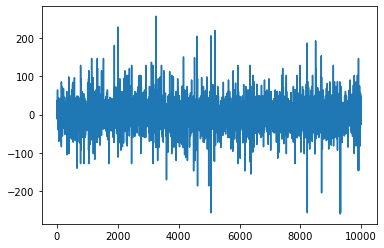

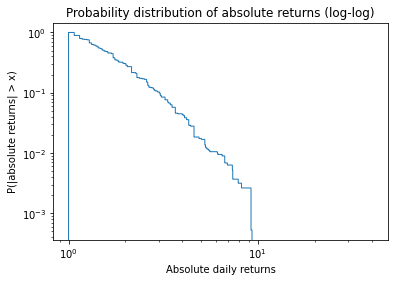

In [11]:
# logarithmic bins
bin=np.logspace(start=0, stop=np.log(5), num=t)

# normalised returns
returns = [(abs(day) - np.mean(model_test.daily_returns)) / np.std(model_test.daily_returns) for day in model_test.daily_returns]

plt.plot(model_test.daily_returns)
plt.show()

plt.figure(1)
plt.hist(returns, bin, cumulative=-1, density=True, log=True, histtype='step')
plt.title("Probability distribution of absolute returns (log-log)")
plt.xlabel("Absolute daily returns")
plt.ylabel("P(|absolute returns| > x)")
plt.gca().set_xscale("log")
plt.show()


In [12]:
class Stochastic_Model:
    def __init__(self, n: int, p: float, init: int, time_horizon: bool, M, d):
        self.returns = [init]
        self.n = n
        self.p = p
        self.time_horizon = time_horizon
        self.M = M
        self.d = d

    def time_horizons(self):
        time_horizons = []
        alpha = []

        # distribution of agents in different time horizons
        # agents are allocated to each time horizon (with exponential decay as we go back in time), until we reach the limit M
        # or until we reach the beginning of the simulation (if current timestep t < M)
        for i in range(1, self.M + 1):
            if len(self.returns) == 1:
                value = (i ** -self.d) * abs(self.returns[-1])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            elif i >= len(self.returns):
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[0])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            else:
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[-1-i])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

        return sum(time_horizons) * (sum(alpha) ** -1)

    def step(self):

        # Agents only factor in the returns at the previous timestep
        if self.time_horizon == False:
            variance  = 2 * p * n * abs(self.returns[-1])
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)
        
        # Agents look back M timesteps
        if self.time_horizon == True:
            horizons = self.time_horizons()
            variance  = 2 * p * n * horizons
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)  

In [13]:
# Stochastic simulation

stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)

for i in range(t):
    stochastic.step()
    stochastic_horizons.step()

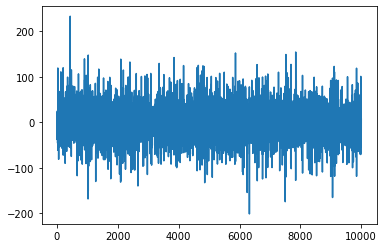

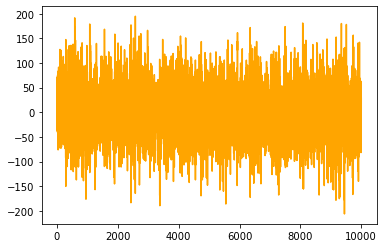

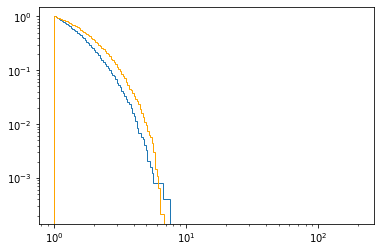

In [14]:
#stochastic simulation return plots
plt.plot(range(t + 1), stochastic.returns)
plt.show()

plt.plot(range(t+1), stochastic_horizons.returns, color='orange')
plt.show()

abs_returns = [(abs(i) - np.mean(stochastic.returns)) / (np.std(stochastic.returns)) for i in stochastic.returns]
abs_returns_horizons = [(abs(i) - np.mean(abs_returns)) / (np.std(stochastic.returns)) for i in stochastic_horizons.returns]
bin=np.logspace(start=0, stop=np.log(10), num=200)

plt.hist(abs_returns, bins=bin, cumulative=-1, density=True, log=True, histtype='step')
plt.hist(abs_returns_horizons, bin, cumulative=-1, density=True, log=True, histtype='step', color = 'orange')
plt.gca().set_xscale("log")
plt.show()

In [15]:
# calculation of returns following feng et al. (2012) method:
df_real_returns_log_difference = df_close_clean.apply(np.log) - df_open_clean.apply(np.log) 

# taking absolute of real returns
df_real_returns_log_difference_abs = df_real_returns_log_difference.abs()

# taking pct change returns
df_real_returns_pct_change = ((df_close_clean - df_open_clean)/df_open_clean).dropna()

In [16]:
df_real_returns_pct_change.abs()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.006877,0.018950,0.013607,0.008649,0.005727,0.002294,0.007740,0.000000,0.021749,0.011076,...,0.022807,0.014609,0.012949,0.010480,0.007459,0.004705,0.005037,0.001479,0.022977,0.005027
2013-01-03,0.002146,0.025678,0.004942,0.010550,0.004857,0.003215,0.011246,0.000452,0.000727,0.010225,...,0.001030,0.006494,0.003286,0.001017,0.002222,0.003273,0.006703,0.013879,0.005148,0.001364
2013-01-04,0.017086,0.067391,0.011959,0.018567,0.006644,0.010875,0.007801,0.007222,0.003918,0.006600,...,0.004786,0.007087,0.002561,0.005198,0.005427,0.005089,0.013049,0.004366,0.003950,0.028610
2013-01-07,0.001174,0.003381,0.003008,0.003640,0.009078,0.002975,0.009691,0.003383,0.004520,0.003438,...,0.006143,0.003810,0.006232,0.004303,0.005161,0.006620,0.001471,0.006254,0.008134,0.000888
2013-01-08,0.006122,0.018133,0.013667,0.007369,0.016915,0.000229,0.001802,0.001584,0.007708,0.009529,...,0.009867,0.000413,0.003325,0.007515,0.005901,0.009283,0.009938,0.001735,0.006888,0.018222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.001476,0.015987,0.009725,0.007180,0.001775,0.004728,0.004737,0.007471,0.001129,0.010299,...,0.014171,0.000124,0.014155,0.016176,0.016608,0.001095,0.003660,0.005955,0.005509,0.003521
2022-12-27,0.002144,0.007132,0.012144,0.010276,0.003058,0.005882,0.002030,0.003787,0.002294,0.008609,...,0.003188,0.035359,0.008170,0.008420,0.004385,0.006637,0.004640,0.002205,0.006617,0.003905
2022-12-28,0.011283,0.015975,0.002415,0.027994,0.008980,0.012975,0.010915,0.016805,0.011199,0.020086,...,0.024833,0.041068,0.009961,0.013921,0.037589,0.016964,0.006759,0.011378,0.014532,0.018416


In [17]:
# Flattening dataframes to combine all the percentage changes for figures
real_returns_pct_change_flattened = df_real_returns_pct_change.abs().dropna().values.flatten()
real_returns_log_difference_abs_flattened = df_real_returns_log_difference_abs.values.flatten()

In [18]:
sorted_non_log = sorted(real_returns_pct_change_flattened)
sorted_log = sorted(real_returns_log_difference_abs_flattened)

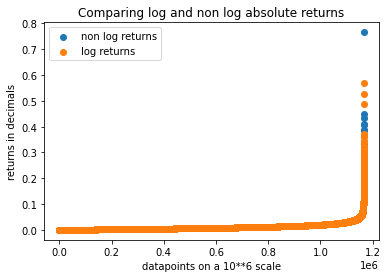

In [19]:
x = np.arange(0, len(sorted_non_log), 1)
plt.scatter(x, sorted_non_log, label='non log returns')
plt.scatter(x, sorted_log, label ='log returns')
plt.title('Comparing log and non log absolute returns')
plt.xlabel('datapoints on a 10**6 scale')
plt.ylabel('returns in decimals')
plt.legend()
plt.show()

In [39]:
real_returns_log_difference_abs_flattened = real_returns_log_difference_abs_flattened/10

In [37]:
y_1_stoch = np.array(abs_returns_horizons)
y_2_stoch = np.array(abs_returns)
y_3_ABM = np.array(returns)

return_datasets = [y_1_stoch, y_2_stoch, y_3_ABM, real_returns_pct_change_flattened*100, real_returns_log_difference_abs_flattened]
labels = ['Stochastic model with time horizons', 'Stochastic model without time horizons', 'Agent based model', 'Real returns pct change', 'Real returns log difference']


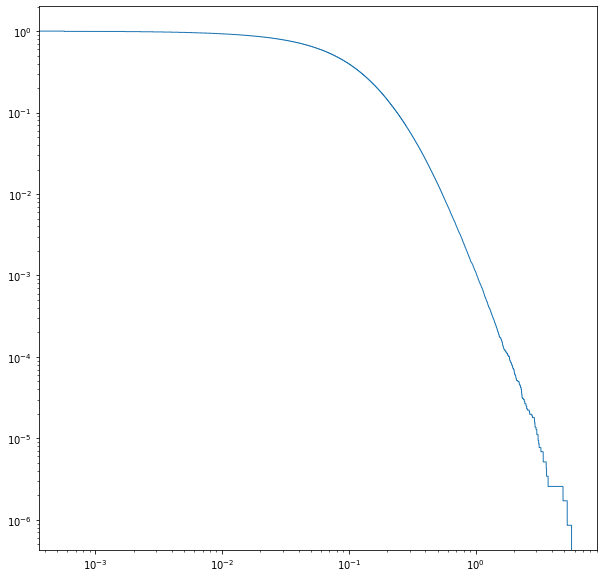

In [40]:
plt.figure(figsize=(10,10))
plt.hist(real_returns_log_difference_abs_flattened, bins=10000, cumulative=-1, density=True, log=True, histtype='step')
# for i in range(len(return_datasets)):
#     plt.hist(return_datasets[i], bins=10000, cumulative=-1, density=True, log=True, histtype='step', label = labels[i])
plt.gca().set_xscale("log")
plt.show()

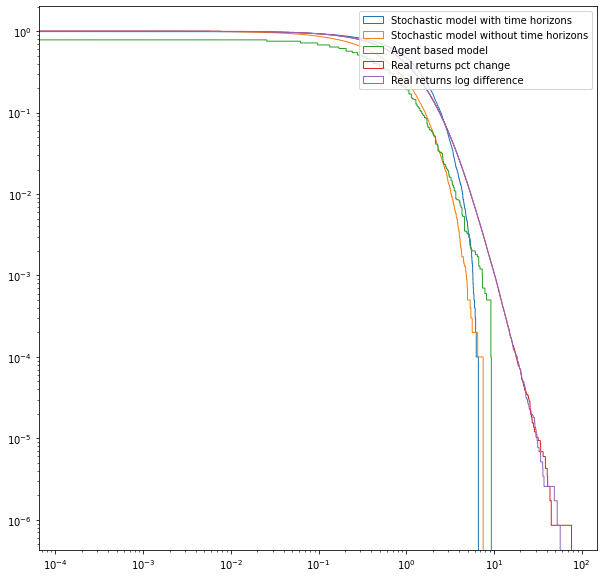

In [38]:
# non-log plot
plt.figure(figsize=(10,10))
for i in range(len(return_datasets)):
    plt.hist(return_datasets[i], bins=10000, cumulative=-1, density=True, log=True, histtype='step', label = labels[i])
plt.gca().set_xscale("log")
plt.legend()
plt.show()

In [26]:
# code for kolmogorov-smirnov test for similarity of distributions: reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html
# assumed samples are independent

# making a matrix in which ks test results will be visualised

array_for_ks_test_results = np.zeros(((len(return_datasets), len(return_datasets))))
for i in range(len(return_datasets)):
    for j in range(len(return_datasets)):
        # returning the 1st element of ks test result as this is the p-value of the ks test
        # print(stats.kstest(return_datasets[i], return_datasets[j])[1])
            array_for_ks_test_results[i,j] = stats.kstest(return_datasets[i], return_datasets[j])[1]

In [27]:
df_of_kstest_results = pd.DataFrame(array_for_ks_test_results)
df_of_kstest_results

,0,1,2,3,4
0,1.000000e+00,9.560579e-263,0.000000e+00,1.495857e-52,9.808338e-53
1,9.560579e-263,1.000000e+00,1.234992e-211,4.487861e-251,7.385038e-251
2,0.000000e+00,1.234992e-211,1.000000e+00,0.000000e+00,0.000000e+00
3,1.495857e-52,4.487861e-251,0.000000e+00,1.000000e+00,1.000000e+00
4,9.808338e-53,7.385038e-251,0.000000e+00,1.000000e+00,1.000000e+00


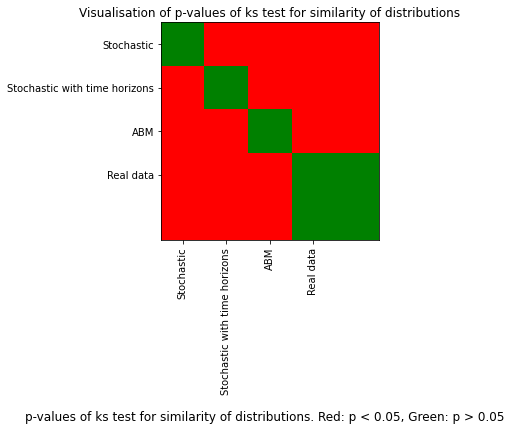

In [28]:
color_matrix = np.where(array_for_ks_test_results < 0.05, 0,1)
cmap = (mpl.colors.ListedColormap(['red', 'green']))
plt.imshow(color_matrix, cmap=cmap, vmin=0, vmax=1)
plt.xticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'], rotation = 90)
plt.yticks([0,1,2,3], ['Stochastic', 'Stochastic with time horizons', 'ABM', 'Real data'])
plt.title("Visualisation of p-values of ks test for similarity of distributions")
plt.figtext(0.5, -0.5, "p-values of ks test for similarity of distributions. Red: p < 0.05, Green: p > 0.05", wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Code below this is unfinished / not used yet

In [ ]:
def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """    
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = int(len(Y)*0.01)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
        
        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax
  
    kappa = 1. / Hill_est
    return kappa

n = int(len(sorted_log)*0.01)
data = np.array(sorted_log)

Hill_estimator(data)

In [29]:
def regression(data_x, data_y, alpha, beta, learning_rate, iterations):
    rmse = math.sqrt(np.mean([((alpha + beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))]))

    for i in range(iterations):
        # find differentials of the parametres
        diff_alpha = 2 * np.mean([(data_x[i] * beta) for i in range(len(data_y))])
        diff_beta = 2 * np.mean([(data_x[i] * beta) * data_x[i] for i in range(len(data_y))])

        alpha_new = alpha - (learning_rate * diff_alpha)
        beta_new = beta - (learning_rate * diff_beta)

        rmse_zero_new = math.sqrt(np.mean([((alpha + beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))]))

        # keep new parametres if they lead to smaller rmse
        if rmse_zero_new < rmse_zero[-1]:
            alpha = alpha_new
            beta = beta_new
            rmse_zero = rmse_zero_new

    return alpha, beta, rmse

In [30]:
def r_squared(data, alpha, beta, x_range):
    """
    Goodness of fit test for regression
    """
    ss_res = []
    ss_total = []
    mean = np.mean(data)

    for i in range(x_range):
        prediction = alpha + beta * x_range[i]
        value = data[i]

        residual = (value - prediction) ** 2
        total = (value - mean) ** 2

        ss_res.append(residual)
        ss_total.append(total)

    return 1 - (ss_res / ss_total)


In [31]:
# k_test - think about ways to fit a power law
k_range = [i*0.1 for i in range(1, 51)]
variances = []

for i in k_range:
    k = i
    k_test = Model(p, n, k, omega)
    for step in range(t):
        k_test.step()

    variance = np.std(k_test) ** 2
    variances.append(variance)

TypeError: __init__() missing 1 required positional argument: 'omega'

In [44]:
# k - regression (if beta > 0, there is a relationship)
k_r = regression(k_range, variances, 0, 10, 1000)
k_test = r_squared(variances, k_r[0], k_r[1], k_range)


TypeError: regression() missing 1 required positional argument: 'iterations'

In [45]:
# omega_test - think about ways to fit a power law
omega_range = [i*0.1 for i in range(1, 51)]
variances = []

for i in omega_range:
    omega = i
    omega_test = Model(p, n, k, omega)
    for step in range(t):
        omega_test.step()

    variance = np.std(omega_test) ** 2
    variances.append(variance)

TypeError: __init__() missing 1 required positional argument: 'omega'

In [46]:
# omega - calculate regression of power law exponent and variances
omega_r = regression(omega_range, variances, 3, 2)
omega_test = r_squared(variances, omega_r[0], omega_r[1], omega_range)


TypeError: regression() missing 2 required positional arguments: 'learning_rate' and 'iterations'

In [ ]:
# p_test - variances; mean number of zeros
p_range = [i*0.01 for i in range(1, 101)]
variances = []
zeros = []

for i in p_range:
    p = i
    p_test = Model(p, n, 1, k, omega)
    for step in range(t):
        p_test.step()

    variance = np.std(p_test) ** 2
    variances.append(variance)

    for i in p_test.daily_returns:
        zero = []
        if -0.5 < i < 0.5:
            zero.append(i)
        
        zero_add = sum(zero) / len(p_test.daily_returns)
        zeros.append(zero_add)

In [ ]:
p_zeros_r = regression(p_range, zeros, 5, 5, 1, 1000)
p_variances_r = regression(p_range, variances, 5, 5, 1, 1000)

p_test_zeros = r_squared(zeros, p_zeros_r[0], p_zeros_r[1], p_range)
p_test_variances = r_squared(variances, p_variances_r[0], p_variances_r[1], p_range)



In [ ]:
# Example of parameter generation
parameters = np.arange(0, 10, 1)
print("parameters to test:", parameters)


def gridsearch(real, abm_or_stoch, parameters):
    best_param = 0
    best_loss = 1000000000
    for param in parameters:
        if abm_or_stoch == 'abm':
            model_test = Model(p, n, size, k, omega) # change the parameter to test to "param"
            for i in range(t):
                model_test.step()
            abs_returns = [abs(day) for day in model_test.daily_returns]
            result = np.array(abs_returns)
        else:
            stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
            stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)
            for i in range(t):
                stochastic.step()
                stochastic_horizons.step()
            abs_returns = [abs(i) for i in stochastic.returns]
            result = np.array(abs_returns)
        rmse = np.sqrt(mean_squared_error(real, result))
        if rmse < best_loss:
            best_param = current_param
            best_loss = rmse
    return best_param, best_loss

# Implementation from https://archive.lib.msu.edu/crcmath/math/math/l/l142.html
def exp_lsq(x, y):
    n = len(bin) # sample size?
    ln_y = np.log(y, where= y != 0)
    sum_ln_y = np.sum(ln_y)
    sum_x = np.sum(x)
    sum_x_ln_y = np.sum(x * ln_y)
    print('sum_ln_y', sum_ln_y, 'sum_x', sum_x)
    a = (sum_ln_y * sum_x**2 - sum_x*sum_x_ln_y) / (n * np.sum(x**2) - sum_x**2)
    b = (n * sum_x_ln_y - sum_x*sum_ln_y)/(n * np.sum(x**2) - sum_x**2)
    return a, b

In [ ]:
a, b = exp_lsq(bin, real_bins)
print(a,b)
x = np.arange(0, len(bin), 1)
y = np.exp(a)*math.e**(b*x)
plt.scatter(x,y)